# SPM Tutorial #3: Looking at the Data

## Objectives
- Inspect anatomical image
- Inspect functional images
- View time-series for sub-08 run-2 and compare to run-1

## Notes
- Unzip or fetch images before loading into the viewer
- Brightness varies with tissue type, slice content, and normalization

In [1]:
%pip install nibabel


[notice] A new release of pip is available: 25.2 -> 26.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


Fetching ds000102/sub-01/anat/sub-01_T1w.nii.gz...
get(ok): sub-01/anat/sub-01_T1w.nii.gz (file) [from s3-PUBLIC...]
Loading anatomical image: ds000102/sub-01/anat/sub-01_T1w.nii.gz


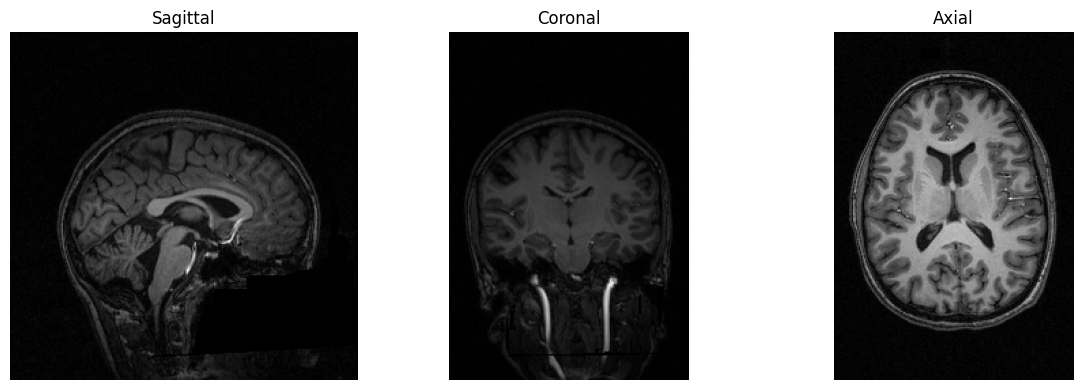

In [1]:
from pathlib import Path
import shutil
import subprocess
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt

bids_root = Path("ds000102")
anat_files = sorted(bids_root.glob("sub-01/anat/*T1w.nii.gz"))
datalad = shutil.which("datalad")

if not anat_files:
    print("No anatomical files found for sub-01.")
else:
    anat_file = anat_files[0]
    if datalad and (not anat_file.exists() or anat_file.is_symlink()):
        print(f"Fetching {anat_file}...")
        subprocess.run([datalad, "get", str(anat_file.relative_to(bids_root))], cwd=bids_root)
    print(f"Loading anatomical image: {anat_file}")
    anat_img = nib.load(anat_file)
    anat_data = anat_img.get_fdata()
    mid_x, mid_y, mid_z = [d // 2 for d in anat_data.shape]
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    axes[0].imshow(anat_data[mid_x, :, :].T, cmap='gray', origin='lower')
    axes[0].set_title('Sagittal')
    axes[1].imshow(anat_data[:, mid_y, :].T, cmap='gray', origin='lower')
    axes[1].set_title('Coronal')
    axes[2].imshow(anat_data[:, :, mid_z].T, cmap='gray', origin='lower')
    axes[2].set_title('Axial')
    for ax in axes:
        ax.axis('off')
    plt.tight_layout()
    plt.show()

In [2]:
import os
import numpy as np
import nibabel as nib
import shutil
import subprocess
from pathlib import Path

bids_root = Path("ds000102")
bold_file = Path("sub-01/func/sub-01_task-flanker_run-1_bold.nii.gz")
full_bold_path = bids_root / bold_file
datalad = shutil.which("datalad")

if datalad and (not full_bold_path.exists() or full_bold_path.is_symlink()):
    print(f"Fetching BOLD data: {bold_file}")
    subprocess.run([datalad, "get", str(bold_file)], cwd=bids_root)

print("\n" + "=" * 70)
print("fMRI DATA EXPLORATION - Subject 01, Run 1")
print("=" * 70)

img = nib.load(full_bold_path)
data = img.get_fdata()
affine = img.affine
header = img.header

print(f"\nImage dimensions: {data.shape}")
print(f"  X (left-right): {data.shape[0]} voxels")
print(f"  Y (anterior-posterior): {data.shape[1]} voxels")
print(f"  Z (superior-inferior): {data.shape[2]} voxels")
print(f"  Time points: {data.shape[3]} TRs")

voxel_dims = np.sqrt(np.sum(affine[:3, :3]**2, axis=0))
print(f"\nVoxel dimensions: {voxel_dims}")
print(f"  X: {voxel_dims[0]:.2f} mm")
print(f"  Y: {voxel_dims[1]:.2f} mm")
print(f"  Z: {voxel_dims[2]:.2f} mm")

tr = header['pixdim'][4]
print(f"\nRepetition Time (TR): {tr:.2f} seconds")
print(f"Total scan duration: {data.shape[3] * tr:.1f} seconds ({data.shape[3] * tr / 60:.1f} minutes)")

print("\n" + "=" * 70)
print("DATA QUALITY METRICS")
print("=" * 70)
print(f"\nIntensity statistics (across all voxels and time points):")
print(f"  Min: {data.min():.1f}")
print(f"  Max: {data.max():.1f}")
print(f"  Mean: {data.mean():.1f}")
print(f"  Std Dev: {data.std():.1f}")
print(f"  Signal-to-Noise Ratio: {data.mean() / data.std():.2f}")

mean_intensity = np.mean(data.reshape(-1, data.shape[3]), axis=0)
print(f"\nMean intensity across volumes:")
print(f"  Range: {mean_intensity.min():.1f} - {mean_intensity.max():.1f}")
print(f"  Std Dev: {mean_intensity.std():.2f}")
intensity_change = np.diff(mean_intensity)
print(f"  Max consecutive volume change: {np.max(np.abs(intensity_change)):.2f} ({np.argmax(np.abs(intensity_change))+1} to {np.argmax(np.abs(intensity_change))+2})")

Fetching BOLD data: sub-01/func/sub-01_task-flanker_run-1_bold.nii.gz

fMRI DATA EXPLORATION - Subject 01, Run 1

Image dimensions: (64, 64, 40, 146)
  X (left-right): 64 voxels
  Y (anterior-posterior): 64 voxels
  Z (superior-inferior): 40 voxels
  Time points: 146 TRs

Voxel dimensions: [3. 3. 4.]
  X: 3.00 mm
  Y: 3.00 mm
  Z: 4.00 mm

Repetition Time (TR): 2.00 seconds
Total scan duration: 292.0 seconds (4.9 minutes)

DATA QUALITY METRICS

Intensity statistics (across all voxels and time points):
  Min: 0.0
  Max: 1548.0
  Mean: 187.4
  Std Dev: 286.6
  Signal-to-Noise Ratio: 0.65

Mean intensity across volumes:
  Range: 186.4 - 188.2
  Std Dev: 0.42
  Max consecutive volume change: 1.60 (60 to 61)



A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.3.5 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/Users/abhishekgautam/anaconda3/lib/python3.11/site-packages/ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "/Users/abhishekgautam/anaconda3/lib/python3.11/site-packages/traitlets/config/application.py", line 992, in launch_instance
    app.start()
  File "/Users/abhishekgautam/anaconda3/lib/python3.11/site-packages/ipykernel/kernelapp.py", line 736, in start
    self.io_loop.s

AttributeError: _ARRAY_API not found


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.3.5 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/Users/abhishekgautam/anaconda3/lib/python3.11/site-packages/ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "/Users/abhishekgautam/anaconda3/lib/python3.11/site-packages/traitlets/config/application.py", line 992, in launch_instance
    app.start()
  File "/Users/abhishekgautam/anaconda3/lib/python3.11/site-packages/ipykernel/kernelapp.py", line 736, in start
    self.io_loop.s

AttributeError: _ARRAY_API not found


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.3.5 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/Users/abhishekgautam/anaconda3/lib/python3.11/site-packages/ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "/Users/abhishekgautam/anaconda3/lib/python3.11/site-packages/traitlets/config/application.py", line 992, in launch_instance
    app.start()
  File "/Users/abhishekgautam/anaconda3/lib/python3.11/site-packages/ipykernel/kernelapp.py", line 736, in start
    self.io_loop.s

AttributeError: _ARRAY_API not found


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.3.5 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/Users/abhishekgautam/anaconda3/lib/python3.11/site-packages/ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "/Users/abhishekgautam/anaconda3/lib/python3.11/site-packages/traitlets/config/application.py", line 992, in launch_instance
    app.start()
  File "/Users/abhishekgautam/anaconda3/lib/python3.11/site-packages/ipykernel/kernelapp.py", line 736, in start
    self.io_loop.s

AttributeError: _ARRAY_API not found

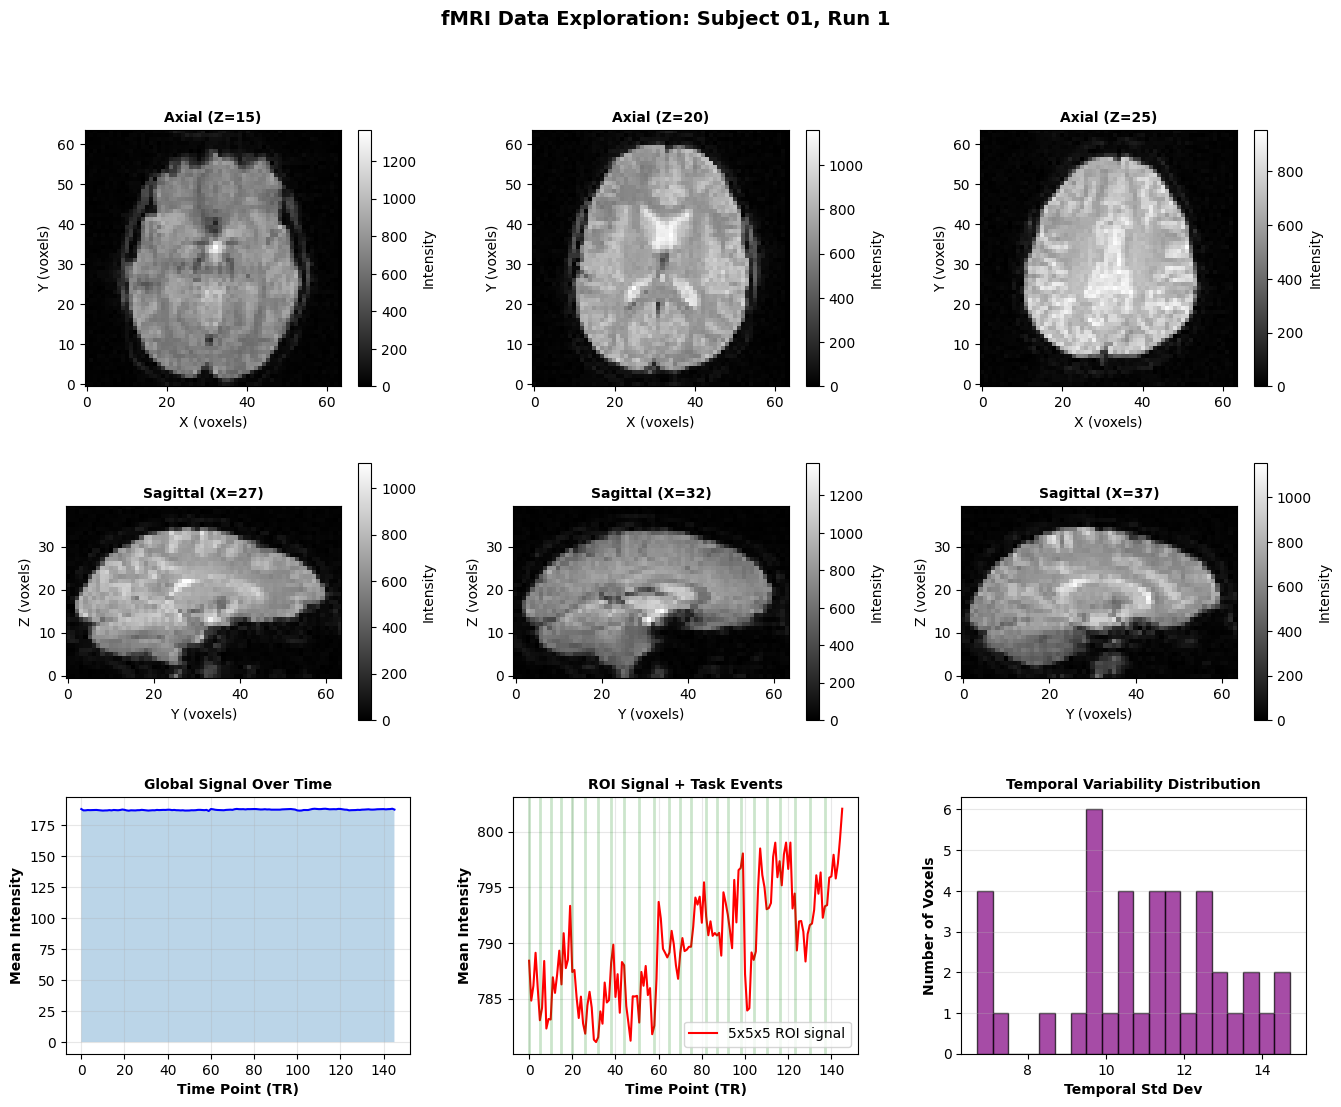


✓ fMRI Data Visualization Complete


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import nibabel as nib

# Load events for overlay
events_run1 = pd.read_csv("ds000102/sub-01/func/sub-01_task-flanker_run-1_events.tsv", sep="\t")

## fMRI Data Visualizations
fig = plt.figure(figsize=(16, 12))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)
fig.suptitle('fMRI Data Exploration: Subject 01, Run 1', fontsize=14, fontweight='bold')

img = nib.load(full_bold_path)
data_viz = img.get_fdata()

mid_x, mid_y, mid_z = [d // 2 for d in data_viz.shape[:3]]
mid_t = data_viz.shape[3] // 2

for idx, z in enumerate([mid_z - 5, mid_z, mid_z + 5]):
    ax = fig.add_subplot(gs[0, idx])
    slice_data = data_viz[:, :, z, mid_t]
    im = ax.imshow(slice_data.T, cmap='gray', origin='lower')
    ax.set_title(f'Axial (Z={z})', fontweight='bold', fontsize=10)
    ax.set_xlabel('X (voxels)')
    ax.set_ylabel('Y (voxels)')
    plt.colorbar(im, ax=ax, label='Intensity')

for idx, x in enumerate([mid_x - 5, mid_x, mid_x + 5]):
    ax = fig.add_subplot(gs[1, idx])
    slice_data = data_viz[x, :, :, mid_t]
    im = ax.imshow(slice_data.T, cmap='gray', origin='lower')
    ax.set_title(f'Sagittal (X={x})', fontweight='bold', fontsize=10)
    ax.set_xlabel('Y (voxels)')
    ax.set_ylabel('Z (voxels)')
    plt.colorbar(im, ax=ax, label='Intensity')

ax = fig.add_subplot(gs[2, 0])
mean_over_space = np.mean(data_viz, axis=(0, 1, 2))
ax.plot(mean_over_space, 'b-', linewidth=1.5)
ax.fill_between(range(len(mean_over_space)), mean_over_space, alpha=0.3)
ax.set_xlabel('Time Point (TR)', fontweight='bold')
ax.set_ylabel('Mean Intensity', fontweight='bold')
ax.set_title('Global Signal Over Time', fontweight='bold', fontsize=10)
ax.grid(alpha=0.3)

ax = fig.add_subplot(gs[2, 1])
roi_signal = data_viz[mid_x-2:mid_x+3, mid_y-2:mid_y+3, mid_z-2:mid_z+3, :].mean(axis=(0,1,2))
ax.plot(roi_signal, 'r-', linewidth=1.5, label='5x5x5 ROI signal')
for event in events_run1.itertuples():
    ax.axvline(event.onset / tr, color='green', alpha=0.2, linewidth=2)
ax.set_xlabel('Time Point (TR)', fontweight='bold')
ax.set_ylabel('Mean Intensity', fontweight='bold')
ax.set_title('ROI Signal + Task Events', fontweight='bold', fontsize=10)
ax.legend()
ax.grid(alpha=0.3)

ax = fig.add_subplot(gs[2, 2])
temporal_std = np.std(data_viz, axis=3)
temporal_std_mean = np.mean(temporal_std, axis=(0, 1))
ax.hist(temporal_std_mean, bins=20, color='purple', alpha=0.7, edgecolor='black')
ax.set_xlabel('Temporal Std Dev', fontweight='bold')
ax.set_ylabel('Number of Voxels', fontweight='bold')
ax.set_title('Temporal Variability Distribution', fontweight='bold', fontsize=10)
ax.grid(alpha=0.3, axis='y')

plt.savefig('fmri_data_exploration.png', dpi=100, bbox_inches='tight')
plt.show()

print("\n✓ fMRI Data Visualization Complete")

Fetching sub-08/func/sub-08_task-flanker_run-1_bold.nii.gz...
get(ok): sub-08/func/sub-08_task-flanker_run-1_bold.nii.gz (file) [from s3-PUBLIC...]
Fetching sub-08/func/sub-08_task-flanker_run-2_bold.nii.gz...
get(ok): sub-08/func/sub-08_task-flanker_run-2_bold.nii.gz (file) [from s3-PUBLIC...]
Run-1 sudden changes (volume indices, 1-based): []
Run-2 sudden changes (volume indices, 1-based): [2, 64]


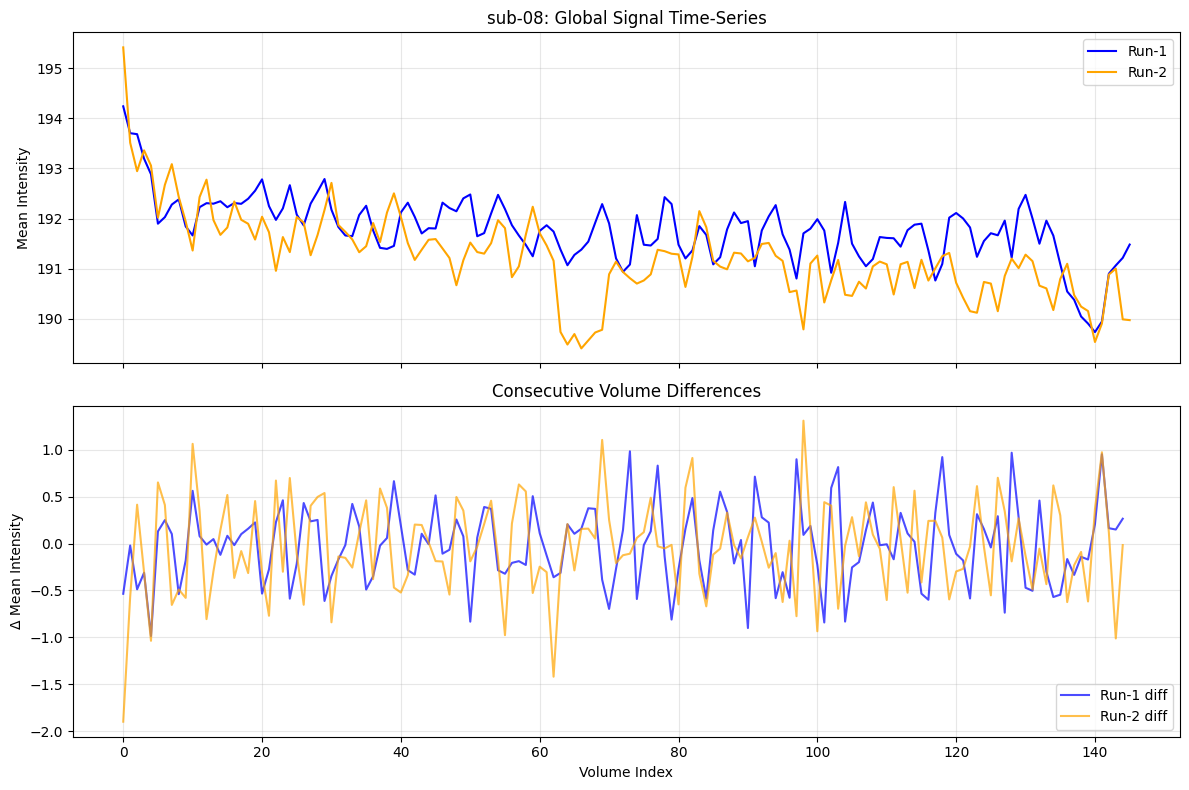

In [4]:
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
import shutil
import subprocess
from pathlib import Path

bids_root = Path("ds000102")
sub_id = "sub-08"
run1_file = Path(f"{sub_id}/func/{sub_id}_task-flanker_run-1_bold.nii.gz")
run2_file = Path(f"{sub_id}/func/{sub_id}_task-flanker_run-2_bold.nii.gz")
datalad = shutil.which("datalad")

for f in [run1_file, run2_file]:
    if datalad and (not (bids_root / f).exists() or (bids_root / f).is_symlink()):
        print(f"Fetching {f}...")
        subprocess.run([datalad, "get", str(f)], cwd=bids_root)

img1 = nib.load(bids_root / run1_file)
img2 = nib.load(bids_root / run2_file)
data1 = img1.get_fdata()
data2 = img2.get_fdata()

ts1 = np.mean(data1.reshape(-1, data1.shape[3]), axis=0)
ts2 = np.mean(data2.reshape(-1, data2.shape[3]), axis=0)

diff1 = np.diff(ts1)
diff2 = np.diff(ts2)

def find_spikes(diff, z_thresh=3.0):
    z = (np.abs(diff) - np.mean(np.abs(diff))) / (np.std(np.abs(diff)) + 1e-8)
    spike_idx = np.where(z > z_thresh)[0]
    return spike_idx, z

spikes1, z1 = find_spikes(diff1)
spikes2, z2 = find_spikes(diff2)

print("Run-1 sudden changes (volume indices, 1-based):", (spikes1 + 2).tolist())
print("Run-2 sudden changes (volume indices, 1-based):", (spikes2 + 2).tolist())

fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
axes[0].plot(ts1, label='Run-1', color='blue')
axes[0].plot(ts2, label='Run-2', color='orange')
axes[0].set_title(f"{sub_id}: Global Signal Time-Series")
axes[0].set_ylabel("Mean Intensity")
axes[0].legend()
axes[0].grid(alpha=0.3)

axes[1].plot(diff1, label='Run-1 diff', color='blue', alpha=0.7)
axes[1].plot(diff2, label='Run-2 diff', color='orange', alpha=0.7)
axes[1].set_title("Consecutive Volume Differences")
axes[1].set_xlabel("Volume Index")
axes[1].set_ylabel("Δ Mean Intensity")
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()